In [1]:
'''
DeepDA_verify is to verify DA output. 
It read proxy, prior, and posterior from DA outputs files and config file.
It calculates the statistics of the DA results and save the outputs.
By Mingsong Li
Penn State
2/17/2020
Updated Mar. 3. 2020
    for Monte Carlo simulations:
'''
from DeepDA_lib import modules_nc
from DeepDA_lib import DeepDA_psm
from scipy import stats
import shutil

import h5py
#import time
import yaml
import numpy as np
import pandas
import os
from netCDF4 import Dataset
from sys import platform as sys_pf
import matplotlib.pyplot as plt
if sys_pf == 'darwin':
    import matplotlib
    matplotlib.use("TkAgg")
    import matplotlib.pyplot as plt
%matplotlib inline

try:
    import bayspline
except ImportError as e1:
    print('Warning:', e1)
try:
    import bayspar
except ImportError as e2:
    print('Warning:', e2)
try:
    import bayfox
except ImportError as e3:
    print('Warning:', e3)
try:
    import baymag
except ImportError as e4:
    print('Warning:', e4)

print('>>  Import package => OKAY')
print('')
#####################    User defined start   #####################

reconi = 1  # 0 = prePETM; 1 = peakPETM

if reconi == 0:
    en = 'petmproxy3slices_v0.0.12.csv_petm11_v12_20200427_all_glassy_preP2_noCaCO3'    # prePETM
elif reconi == 1:
    en = 'petmproxy3slices_v0.0.12.csv_petm9_v12_20200427_all_glassy_pre_peak_noCaCO3' # peakPETM

dum_jmax = 36
dum_imax = 36
dum_ijmax = dum_imax * dum_jmax

AnalysisStd = True   # True: standardize; False: use raw analysis data

#####################    User defined end     #####################

config_name_f = "DeepDA_config.yml"
f = open(config_name_f, 'r')
yml_dict_f = yaml.load(f, Loader=yaml.FullLoader)
f.close()

dir_data_save = yml_dict_f['core']['wrkdir']

config_name = dir_data_save + '/' + en + '.yml'
f = open(config_name, 'r')
yml_dict = yaml.load(f, Loader=yaml.FullLoader)
f.close()
print('>>  Loading configuration file => OKAY')
print('')
# Read parameters from configurations
MCn = yml_dict['MonteCarlo']['number']
nens = yml_dict['core']['nens']

nexp = yml_dict['core']['nexp']
dir_data_save = yml_dict['core']['wrkdir']

recon_period = yml_dict['core']['recon_period']
recon_timescale = yml_dict['core']['recon_timescale_interval']
recon_period_full = np.arange(recon_period[0],recon_period[1]+1,recon_timescale)
recon_period_len = recon_period_full.shape[0]
recon_timescale = yml_dict['core']['recon_timescale_interval']
save_ens_full = yml_dict['core']['save_ens_full']
proxy_assim2 = yml_dict['proxies'][yml_dict['proxies']['use_from'][0]]['proxy_assim2']
proxy_psm_type    = yml_dict['proxies'][yml_dict['proxies']['use_from'][0]]['proxy_psm_type']
proxy_err_eval   = yml_dict['proxies'][yml_dict['proxies']['use_from'][0]]['proxy_err_eval']
lon_label = yml_dict['proxies'][yml_dict['proxies']['use_from'][0]]['lon_label']
lat_label = yml_dict['proxies'][yml_dict['proxies']['use_from'][0]]['lat_label']

proxy_frac      = yml_dict['proxies']['proxy_frac']
prior_source = yml_dict['prior']['prior_source'] #
dum_lon_offset = yml_dict['prior'][prior_source]['dum_lon_offset'] # longitude offset
limit_hard_keys = list(yml_dict['prior'][prior_source]['limit_hard'].keys())
print(limit_hard_keys)

data_period_id    = yml_dict['proxies'][yml_dict['proxies']['use_from'][0]]['data_period_id']
data_period_idstd = yml_dict['proxies'][yml_dict['proxies']['use_from'][0]]['data_period_idstd']
recon_period = yml_dict['core']['recon_period']
recon_timescale = yml_dict['core']['recon_timescale_interval']
recon_period_full = np.arange(recon_period[0],recon_period[1]+1,recon_timescale)
recon_period_len = recon_period_full.shape[0]
geologic_age = yml_dict['core']['geologic_age']

# read preprior HDF5 file
dir_proxy_data = dir_data_save +'/'+ yml_dict['proxies'][yml_dict['proxies']['use_from'][0]]['dbversion']
proxy_err_eval = yml_dict['proxies'][yml_dict['proxies']['use_from'][0]]['proxy_err_eval']

# read proxy raw file
proxy_dir = yml_dict['core']['proxy_dir']
proxy_rawfile = proxy_dir +'/'+ yml_dict['proxies'][yml_dict['proxies']['use_from'][0]]['dbversion']
# ========= dataset for plot =========
cGENIEGrid = yml_dict['core']['proj_dir'] + '/data_misc/cGENIEGrid.csv'
cGENIEGrid = pandas.read_csv(cGENIEGrid)
cGENIEGridB_lat36 = cGENIEGrid['lat']
cGENIEGridB_lon36 = cGENIEGrid['lon']
cGENIEGrid = cGENIEGrid.to_numpy()
#print('>>  OKAY.')

# Read global mean and plot to show results
########## Prior #########
prior_state_variable = yml_dict['prior'][prior_source]['state_variable']  # note: ['2d': xxx; '3d': xxx]
dum_lon_offset = yml_dict['prior'][prior_source]['dum_lon_offset'] # longitude offset
# ========= Monte Carlo =========
local_rad_list = yml_dict['core']['local_rad_list'] #
locRadn= len(local_rad_list)
local_rad_list = np.asarray(local_rad_list)
#print(local_rad_list)
#print(locRadn)
proxy_frac_list   = yml_dict['proxies']['proxy_frac']
proxy_fracn = len(proxy_frac_list)
proxy_frac_list = np.asarray(proxy_frac_list)

Rscale_list = yml_dict['core']['Rscale']
Rscalen = len(Rscale_list)
Rscale_list = np.asarray(Rscale_list)

# save prior variable list
prior_variable_dict = []  # variable list
prior_nc_file_list = []  # nc file list
prior_variable_dict_3d = []  # variable list
prior_nc_file_list_3d = []  # nc file list

for key, value in prior_state_variable.items():
    nc_keyvalue = prior_state_variable[key]['ncname']  # note: 2d dict
    print('>>  nc_keyvalue {}...'.format(nc_keyvalue))
    for key1, value1 in nc_keyvalue.items():
        print('>>  {}: {}'.format(key1,value1))
        for i in range(len(prior_state_variable[key][value1])):
            if key in ['2d']:
                prior_variable_dict.append(prior_state_variable[key][value1][i])
                prior_nc_file_list.append(key1+'/'+value1+'.nc')
            elif key in ['3d']:
                prior_variable_dict_3d.append(prior_state_variable[key][value1][i])
                prior_nc_file_list_3d.append(key1+'/'+value1+'.nc')

# variable list
prior_variable_len = len(prior_variable_dict)
prior_variable3d_len = len(prior_variable_dict_3d)
print('>>  Number of 2d prior variables is: {}. List:'.format(prior_variable_len))
print('      {}'.format(prior_variable_dict))
print('>>  Number of 3d prior variables is: {}. List:'.format(prior_variable3d_len))
print('      {}'.format(prior_variable_dict_3d))

MC_dir =  dir_data_save + '/' + en + '/'

Xb2d_prior_np = np.full((dum_jmax*dum_imax,nens,locRadn,proxy_fracn,Rscalen,MCn,prior_variable_len),np.nan)  # save mean of each variable (column) of each MC run (row)
Xa2d_poste_np = np.full((dum_jmax*dum_imax,nens,locRadn,proxy_fracn,Rscalen,MCn,prior_variable_len,recon_period_len),np.nan)  # save mean of each variable (column) of each MC run (row)

Xa2d_mean_np = np.full((locRadn,proxy_fracn,Rscalen,MCn,prior_variable_len,recon_period_len),np.nan)  # save mean of each variable (column) of each MC run (row)
Xa2d_std_np = np.full((locRadn,proxy_fracn,Rscalen,MCn,prior_variable_len,recon_period_len),np.nan)  # save mean of each variable (column) of each MC run (row)
# mean 
Xa2d_all_np = np.full((dum_jmax, dum_imax,locRadn,proxy_fracn,Rscalen,MCn, prior_variable_len, recon_period_len),np.nan)  # save mean of each variable (column) of each MC run (row)
Xa2d_allvar_np = np.full((dum_jmax, dum_imax, locRadn,proxy_fracn,Rscalen,MCn, prior_variable_len, recon_period_len),np.nan)  # save mean of each variable (column) of each MC run (row)
Xa2d_mean_np2 = np.full((locRadn,proxy_fracn,Rscalen,prior_variable_len,recon_period_len),np.nan)  # save mean of each variable (column) of each MC run (row)
Xa2d_std_np2 = np.full((locRadn,proxy_fracn,Rscalen,prior_variable_len,recon_period_len),np.nan)  # save mean of each variable (column) of each MC run (row)

for locRadi in range(locRadn):
    locRad = local_rad_list[locRadi]
    if locRad is None:
        locRadv = 0 # for filename only
    else:
        locRadv = locRad
    for proxy_fraci in range(proxy_fracn):
        proxy_frac = proxy_frac_list[proxy_fraci]
        
        for Rscalei in range(Rscalen):
            Rscale = Rscale_list[Rscalei]
            for MCi in range(MCn):
                # NetCDF file name
                filename_short = '_loc_', str(locRadv),'_proxy_frac_', str(proxy_frac),'_Rscale_',str(Rscale),'_MC_' + str(MCi) 
                nc_filename = MC_dir + ''.join(filename_short) + '.nc'
                hdf5name    = MC_dir + ''.join(filename_short) + '.hdf5'
                
                print('>>  Read nc file: {}'.format(nc_filename))
                for Xa2d_vari in range(prior_variable_len):
                    Xb_full_name_vari = prior_variable_dict[Xa2d_vari] +'_Xb_full'
                    Xa_full_name_vari = prior_variable_dict[Xa2d_vari] +'_Xa_full'
                    Xa_mean_name_vari = prior_variable_dict[Xa2d_vari] +'_Xa_mean'
                    Xa_variance_name_vari = prior_variable_dict[Xa2d_vari] +'_Xa_variance'
                    #print('>>  2d variable name {}'.format(Xa_mean_name_vari))
                    Xb_full_vari = Dataset(nc_filename).variables[Xb_full_name_vari][:]
                    Xa_full_vari = Dataset(nc_filename).variables[Xa_full_name_vari][:]
                    Xa_mean_vari = Dataset(nc_filename).variables[Xa_mean_name_vari][:]
                    Xa_variance_vari = Dataset(nc_filename).variables[Xa_variance_name_vari][:]
                    
                    if prior_variable_dict[Xa2d_vari] in limit_hard_keys:
                        # some variables have hard limitation: e.g., CaCO3 = [0, 100]
                        lim_min = yml_dict['prior'][prior_source]['limit_hard'][prior_variable_dict[Xa2d_vari]]['lim_min']
                        lim_max = yml_dict['prior'][prior_source]['limit_hard'][prior_variable_dict[Xa2d_vari]]['lim_max']
                        #print('limit min {} and max {}'.format(lim_min, lim_max))
                        if lim_min:
                            if np.any(Xa_full_vari<lim_min):
                                Xa_full_vari[Xa_full_vari<lim_min] = lim_min
                                Xa_mean_vari = np.mean(Xa_full_vari,axis=2)
                                Xa_variance_vari = np.var(Xa_full_vari,axis=2)
                                print('>>    Force {} value to be >= {}'.format(prior_variable_dict[Xa2d_vari],lim_min))
                        if lim_max:
                            if np.any(Xa_full_vari>lim_max):
                                Xa_full_vari[Xa_full_vari>lim_max] = lim_max
                                Xa_mean_vari = np.mean(Xa_full_vari,axis=2)
                                Xa_variance_vari = np.var(Xa_full_vari,axis=2)
                                print('>>    Force {} value to be <= {}'.format(prior_variable_dict[Xa2d_vari], lim_max))
                    
                    for reconi in range(recon_period_len):
                        Xa_full_reconi = Xa_full_vari[:,:,:,0,reconi].reshape((dum_ijmax,nens))
                        Xa2d_poste_np[:,:,locRadi,proxy_fraci,Rscalei,MCi,Xa2d_vari,reconi] = np.copy(Xa_full_reconi)
                        
                        Xa_full_reconi_mean = np.nanmean(Xa_full_reconi,axis=0)                        
                        Xa_mean_reconi = Xa_mean_vari[:,:,0,reconi]                        
                        Xa2d_all_np[:,:,locRadi,proxy_fraci,Rscalei,MCi,Xa2d_vari,reconi] = np.copy(Xa_mean_vari[:,:,0,reconi])
                        Xa_mean_reconi_mean = np.nanmean(Xa_mean_reconi)

                        Xa_variance_reconi = Xa_variance_vari[:,:,0,reconi]
                        Xa2d_allvar_np[:,:,locRadi,proxy_fraci,Rscalei,MCi,Xa2d_vari,reconi] = Xa_variance_vari[:,:,0,reconi]
                        Xa_std_reconi_mean = np.sqrt(np.nanmean(Xa_variance_reconi))
                        
                        #print('>>  reconi = {}, mean is {}, std is {}'.format(reconi, Xa_mean_reconi_mean, Xa_std_reconi_mean))
                        
                        #Xa2d_full_np[locRadi,proxy_fraci,Rscalei,MCi*nens:(MCi+1)*nens,Xa2d_vari,reconi] = Xa_full_reconi_mean
                        Xa2d_mean_np[locRadi,proxy_fraci,Rscalei,MCi,Xa2d_vari,reconi] = Xa_mean_reconi_mean
                        Xa2d_std_np[locRadi,proxy_fraci,Rscalei,MCi,Xa2d_vari,reconi] = Xa_std_reconi_mean
                        
                    Xb_full_reconi = Xb_full_vari[:,:,:,0].reshape((dum_ijmax,nens))
                    Xb2d_prior_np[:,:,locRadi,proxy_fraci,Rscalei,MCi,Xa2d_vari] = np.copy(Xb_full_reconi)
                    
            print('First variable: all MC mean')
            print(Xa2d_mean_np[locRadi,proxy_fraci,Rscalei,:,0,0])
            
            Xb2d_prior_np = np.ma.masked_where(Xb2d_prior_np > 9.0e+36, Xb2d_prior_np)
            Xa2d_poste_np = np.ma.masked_where(Xa2d_poste_np > 9.0e+36, Xa2d_poste_np)
            
            #Xa2d_all_np = np.ma.masked_where(Xa2d_all_np > 9.0e+36, Xa2d_all_np)
            Xa2d_allvar_np = np.ma.masked_where(Xa2d_all_np > 9.0e+36, Xa2d_allvar_np)
            for Xa2d_vari in range(prior_variable_len):
                for reconi in range(recon_period_len):
                    Xa2d_mean_np2[locRadi,proxy_fraci,Rscalei,Xa2d_vari,reconi] = np.nanmean(Xa2d_all_np[:,:,locRadi,proxy_fraci,Rscalei,:,Xa2d_vari,reconi])
                    Xa2d_std_np2[locRadi,proxy_fraci,Rscalei,Xa2d_vari,reconi] = np.sqrt(np.nanmean(Xa2d_allvar_np[:,:,locRadi,proxy_fraci,Rscalei,:,Xa2d_vari,reconi]))
            
            np.set_printoptions(precision=6, suppress=True)
            print('All variable. Mean of variables x reconi')
            print('{}'.format(Xa2d_mean_np2[locRadi,proxy_fraci,Rscalei,:,:]))
            #print('std  of variables x reconi')
            #print('{}'.format(Xa2d_std_np2))
#print('mean of variables x reconi'.format(Xa2d_mean_np2))
#print('{}'.format(Xa2d_mean_np2))
#print('std  of variables x reconi'.format(Xa2d_std_np2))
#print('{}'.format(Xa2d_std_np2))

KeyboardInterrupt: 

In [125]:
print(Xb2d_prior_np.shape)

(1296, 200, 1, 1, 1, 20, 8)


1 : /mnt/d/cGENIE/ML.petm/ML.petm007/ML.petm007.ID.1/biogem/fields_biogem_2d.nc & /mnt/d/cGENIE/ML.petm/ML.petm008/ML.petm008.ID.1/biogem/fields_biogem_2d.nc
2 : /mnt/d/cGENIE/ML.petm/ML.petm007/ML.petm007.ID.2/biogem/fields_biogem_2d.nc & /mnt/d/cGENIE/ML.petm/ML.petm008/ML.petm008.ID.2/biogem/fields_biogem_2d.nc
3 : /mnt/d/cGENIE/ML.petm/ML.petm007/ML.petm007.ID.3/biogem/fields_biogem_2d.nc & /mnt/d/cGENIE/ML.petm/ML.petm008/ML.petm008.ID.3/biogem/fields_biogem_2d.nc
4 : /mnt/d/cGENIE/ML.petm/ML.petm007/ML.petm007.ID.4/biogem/fields_biogem_2d.nc & /mnt/d/cGENIE/ML.petm/ML.petm008/ML.petm008.ID.4/biogem/fields_biogem_2d.nc
5 : /mnt/d/cGENIE/ML.petm/ML.petm007/ML.petm007.ID.5/biogem/fields_biogem_2d.nc & /mnt/d/cGENIE/ML.petm/ML.petm008/ML.petm008.ID.5/biogem/fields_biogem_2d.nc
6 : /mnt/d/cGENIE/ML.petm/ML.petm007/ML.petm007.ID.6/biogem/fields_biogem_2d.nc & /mnt/d/cGENIE/ML.petm/ML.petm008/ML.petm008.ID.6/biogem/fields_biogem_2d.nc
7 : /mnt/d/cGENIE/ML.petm/ML.petm007/ML.petm007.ID.7

(36, 36, 75)
[[ 2.254358  1.192523  6.772079  1.939989]
 [23.879766  1.777951 28.398564  1.648529]
 [23.879766  1.777951 28.398564  1.648529]
 [27.922769  1.783069 32.477827  1.670573]
 [27.922769  1.783069 32.477827  1.670573]
 [12.845577  2.014868 18.038003  1.932545]
 [30.756359  1.855446 35.484852  1.732247]
 [30.756359  1.855446 35.484852  1.732247]
 [30.756359  1.855446 35.484852  1.732247]
 [30.756359  1.855446 35.484852  1.732247]
 [30.756359  1.855446 35.484852  1.732247]
 [ 8.835996  2.137244 14.128426  1.96169 ]
 [ 8.835996  2.137244 14.128426  1.96169 ]
 [29.804419  1.773825 34.313056  1.655306]
 [29.804419  1.773825 34.313056  1.655306]
 [24.832919  1.799866 29.421668  1.68067 ]
 [24.832919  1.799866 29.421668  1.68067 ]
 [24.832919  1.799866 29.421668  1.68067 ]
 [15.261953  1.883561 19.909132  1.674195]
 [27.673496  1.821432 32.290501  1.690965]
 [32.674886  1.852334 37.405325  1.730519]
 [32.674886  1.852334 37.405325  1.730519]
 [21.462427  1.797663 26.002814  1.661635

In [130]:
'''
Read proxy, calculate temperate, save output in lmwrk/wrk/ folder
Use this as 'data', use prior, and posterior for comparison
'''

mgsoption = 1 # 1 = evans model; 2 = baymag surface model

if mgsoption == 1:
    sstproxyfileEvans = 'petmproxy3slices_v0.0.12_sst_evans.csv'
    proxy_rawfile = proxy_dir +'/'+ sstproxyfileEvans
else:
    sstproxyfileBaymag = 'petmproxy3slices_v0.0.12_sst_mg_sur.csv'
    proxy_rawfile = proxy_dir +'/'+ sstproxyfileBaymag 

print(' ########## Read proxies database ########## ')

### read proxies database ###
proxies = pandas.read_csv(proxy_rawfile)
proxies_len0 = len(proxies)

print(' {}'.format(proxy_rawfile))
print(' len is {}'.format(proxies_len0))

proxy_order       = yml_dict['proxies'][yml_dict['proxies']['use_from'][0]]['proxy_order']
proxy_blacklist   = yml_dict['proxies'][yml_dict['proxies']['use_from'][0]]['proxy_blacklist']
proxy_list = [item for item in proxy_order if item not in proxy_blacklist]
proxy_d18o_glassy  = yml_dict['proxies']['proxy_d18o_glassy']
proxy_assim3 = yml_dict['proxies'][yml_dict['proxies']['use_from'][0]]['proxy_assim3']
data_glassy_label_blacklist = proxy_assim3['Marine sediments_d18o_pooled_glassy']

proxy_select_0 = 0

for j in range(proxies_len0):
    # Read proxy type from the database
    data_psm_type = proxies['Proxy'][j]
    # initial default 0 : this proxy is not included
    data_assimilate_i = 0
    for jlist in range(len(proxy_list)):
        if data_psm_type in proxy_assim2[proxy_list[jlist]]:
            # find and save this proxy
            data_assimilate_i = 1
    if data_assimilate_i == 1:
        #print('>>    file {}, {} included'.format(proxies.loc[j,'File'], data_psm_type))
        if proxy_select_0 == 0:
            proxy_select0 = proxies.iloc[[j]]
            proxy_select0 = proxy_select0.reset_index(drop=True) # reset_index, avoid index error
            proxy_select_0 = 1
        else:
            #proxy_select.append(proxies.iloc[[j]])
            proxy_select0 = proxy_select0.append(proxies.iloc[[j]], ignore_index=True)
#print('proxy selected {}'.format(proxy_select0))

proxies_select_len0 = len(proxy_select0)
print('>>  Proxy: selected proxy dataset number {}: those in blacklist removed'.format(proxies_select_len0))

### check glassy only data or not
proxy_select_0 = 0
if proxy_d18o_glassy:
    for jj in range(proxies_select_len0):
        data_glassy_label = proxy_select0['Glassy'][jj]
        if data_glassy_label not in data_glassy_label_blacklist:
            if proxy_select_0 == 0:
                proxy_select = proxy_select0.iloc[[jj]]
                proxy_select = proxy_select.reset_index(drop=True) # reset_index, avoid index error
                proxy_select_0 = 1
            else:
                proxy_select = proxy_select.append(proxy_select0.iloc[[jj]], ignore_index=True)

    #print(proxy_select)
    proxies_select_len0 = len(proxy_select)
    print('>>  Proxy: selected proxy dataset number {}: remove those unknown/frosty'.format(proxies_select_len0))
else:
    proxy_select = proxy_select0.copy()
#print(proxy_select)

 ########## Read proxies database ########## 
 /mnt/c/Users/mul450/Dropbox/git/deepDA/mlwrk/proxy/petmproxy3slices_v0.0.12_sst_evans.csv
 len is 41
>>  Proxy: selected proxy dataset number 41: those in blacklist removed
>>  Proxy: selected proxy dataset number 41: remove those unknown/frosty


In [ ]:
nens1 = 75
petm007sst = np.full((dum_jmax,dum_imax,nens1),np.nan)
petm007dir = '/mnt/d/cGENIE/ML.petm/ML.petm007/'
petm008sst = np.full((dum_jmax,dum_imax,nens1),np.nan)
petm008dir = '/mnt/d/cGENIE/ML.petm/ML.petm008/'

for idi in range(nens1):
    
    file7i = petm007dir + 'ML.petm007.ID.' + str(idi+1) + '/biogem/fields_biogem_2d.nc' 
    file8i = petm008dir + 'ML.petm008.ID.' + str(idi+1) + '/biogem/fields_biogem_2d.nc'
    print('{} : {} & {}'.format(idi+1, file7i, file8i))
    file7i_i = Dataset(file7i).variables['ocn_sur_temp'][12,:,:]
    petm007sst[:,:,idi] = np.copy(file7i_i)
    file8i_i = Dataset(file8i).variables['ocn_sur_temp'][12,:,:]
    petm008sst[:,:,idi] = np.copy(file8i_i)

print(petm007sst.shape)

prior_prepeak = np.full((proxies_select_len0,4),np.nan)

for j in range(proxies_select_len0):
    # NOW read SST from proxy
    # read lon lat for each line of proxy
    dum_lat = proxies[lat_label][j]  # (paleo)latitude of this site
    dum_lon = proxies[lon_label][j]  # (paleo)longitude of this site
    lonlat = modules_nc.cal_find_ij(dum_lon,dum_lat,dum_lon_offset,dum_imax,dum_jmax)
    # output [lon, lat], lon ranges from 0 (-180) to 35 (180), lat ranges from 0 (-90) to 35 (90)
    ssti = petm007sst[lonlat[1], lonlat[0],:]
    prior_prepeak[j,0] = np.mean(ssti)
    prior_prepeak[j,1] = np.std(ssti)
    ssti = petm008sst[lonlat[1], lonlat[0],:]
    prior_prepeak[j,2] = np.mean(ssti)
    prior_prepeak[j,3] = np.std(ssti)
    
cols = ['sst_prior_pre', 'sst_prior_pre_std','sst_prior_peak', 'sst_prior_peak_std']
df = proxy_select.join(pandas.DataFrame(prior_prepeak,columns=cols))

dirdir = yml_dict['core']['proj_dir']+'/wrk/' + 'petm007-008.sst.pre-peak-PETM.csv'
df.to_csv(dirdir,index = False)

print(prior_prepeak)
print(dirdir)

In [83]:
#print(proxy_select)

recon_sst = np.full((proxies_select_len0,5),np.nan)  # for saving mean and std of the reconstructed SST for prior and posterior
var_field_xb = 'ocn_sur_temp_Xb_full'
var_field_xa = 'ocn_sur_temp_Xa_full'

if reconi == 0:
    #prePETM
    sstmatrix = np.full((proxies_select_len0,MCn,nens),np.nan)
elif reconi == 1:
    # peakPETM
    sstmatrix = np.full((proxies_select_len0,MCn,nens),np.nan)
    
for j in range(proxies_select_len0):
    # NOW read SST from proxy
    # read lon lat for each line of proxy
    dum_lat = proxies[lat_label][j]  # (paleo)latitude of this site
    dum_lon = proxies[lon_label][j]  # (paleo)longitude of this site
    lonlat = modules_nc.cal_find_ij(dum_lon,dum_lat,dum_lon_offset,dum_imax,dum_jmax)
    # output [lon, lat], lon ranges from 0 (-180) to 35 (180), lat ranges from 0 (-90) to 35 (90)
    Filei = proxies['File'][j]
    print('{}. {}'.format(j, Filei))
    # find 1d grid location
    lonlati = lonlat[1] * dum_jmax + lonlat[0]
    
    ye    = Xb2d_prior_np[lonlati,:,0,0,0,:,0]
    
    if reconi == 0:
        xasst = Xa2d_poste_np[lonlati,:,0,0,0,:,0]
    elif reconi == 1:
        xasst = Xa2d_poste_np[lonlati,:,0,0,0,:,0,1]
    
    
    recon_sst[j,0] = np.mean(ye)
    recon_sst[j,1] = np.std(ye)
    recon_sst[j,2] = np.mean(xasst)
    recon_sst[j,3] = np.std(xasst)
    recon_sst[j,4] = proxies['latbc'][j]
print(recon_sst)

0. sluijs2006-acex302-4a.txt
1. gutjahr2017-dsdp401d18omgca.txt
2. gutjahr2017-dsdp401d18omgca.txt
3. tripati2005-527mgcasoldadoensis.txt
4. tripati2005-527mgcam.subb.txt
5. thomas1996-690d18ofora.txt
6. kozdon2013-865d18omorozovellasims.txt
7. tripati2003-865mgcamorozovella.txt
8. tripati2003-865mgcamorozovella.txt
9. tripati2004-865mgcamorozovella.txt
10. tripati2004-865mgcaasoldadoensis.txt
11. bijl2009-1172.txt
12. sluijs2011-odpsite1172.txt
13. zachos2003-1209mgcam.velascoensis.txt
14. zachos2003-1209mgcaa.soldadoensis.txt
15. sluijs2007-bassriver.txt
16. john2008-bassriverd18o.txt
17. john2008-bassriverd18o.txt
18. schoon2013-fursectionnorthsea.txt
19. sluijs2014-harrellcore.txt
20. frieling2017-ib10aofnigeria.txt
21. frieling2017-ib10bofnigeria.txt
22. john2008-lodod18o.txt
23. john2008-lodod18o.txt
24. john2008-lodod18o.txt
25. frieling2017-sqofnigeria.txt
26. frieling2017-sqofnigeria.txt
27. frieling2017-sqofnigeria.txt
28. frieling2017-sqofnigeria.txt
29. frieling2017-sqofnig

RMSE: prior vs proxy
7.852747401946911
RMSE: analysis vs proxy
6.234318413999853
CE: prior vs proxy
-3.080676190373051
CE: analysis vs proxy
-1.57197556399292


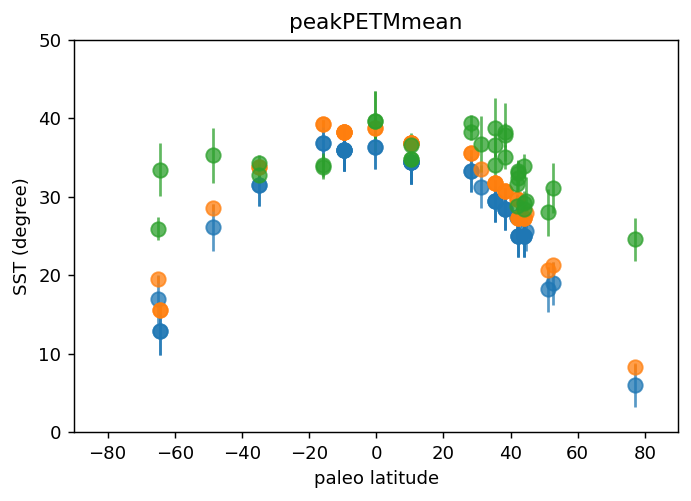

In [85]:
fig = plt.figure()

kwargs = dict(alpha=0.75, marker='o', markersize=8, linestyle='',label = 'Prior')

plt.errorbar(recon_sst[:,4], recon_sst[:,0], yerr = recon_sst[:,1],**kwargs)
plt.errorbar(recon_sst[:,4], recon_sst[:,2], yerr = recon_sst[:,3],**kwargs)

if reconi == 0:
    labelrecon0 = 'sst_prePETMmean'
    labelrecon1 = 'sst_prePETMvar'
    filename1 = 'petmproxy3slices_v0.0.12_sst_DA_prePETM.csv'
elif reconi == 1:
    labelrecon0 = 'sst_peakPETMmean'
    labelrecon1 = 'sst_peakPETMvar'
    filename1 = 'petmproxy3slices_v0.0.12_sst_DA_peakPETM.csv'
plt.errorbar(proxies['latbc'][:], proxies[labelrecon0][:], yerr = np.sqrt(proxies[labelrecon1][:]),**kwargs)

plt.xlim([-90, 90])
plt.ylim([0, 50])
plt.xlabel('paleo latitude')
plt.ylabel('SST (degree)')
plt.title(labelrecon0[4:])
plt.rcParams.update({'figure.figsize':(6,4), 'figure.dpi':130})

datad = proxies[labelrecon0][:]
modeld = recon_sst[:,0]
analysisd = recon_sst[:,2]

print('RMSE: prior vs proxy')
print(np.sqrt(np.nanmean((modeld - datad) ** 2, axis=0)))
print('RMSE: analysis vs proxy')
print(np.sqrt(np.nanmean((analysisd - datad) ** 2, axis=0)))
print('CE: prior vs proxy')
print(DeepDA_psm.CE_NS70(datad, modeld, 1))
print('CE: analysis vs proxy')
print(DeepDA_psm.CE_NS70(datad, analysisd, 1))

cols = ['sst_prior', 'sst_prior_std', 'sst_analysis', 'sst_analysis_std','paleolat']
df = proxy_select.join(pandas.DataFrame(recon_sst,columns=cols))

dirdir = yml_dict['core']['proj_dir']+'/wrk/' + filename1
df.to_csv(dirdir,index = False)

 ########## Read proxies database ########## 


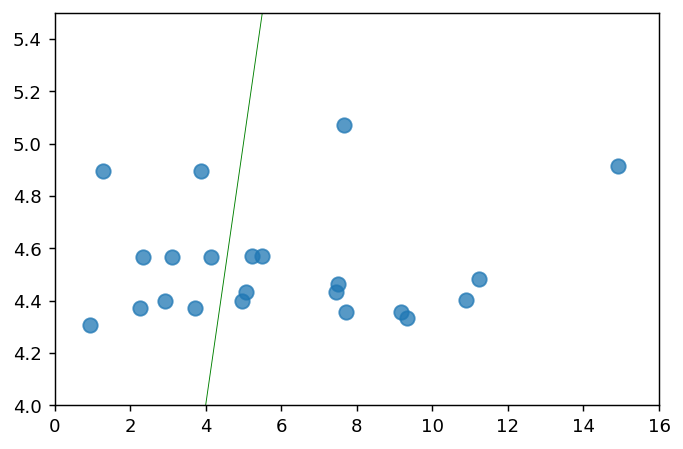

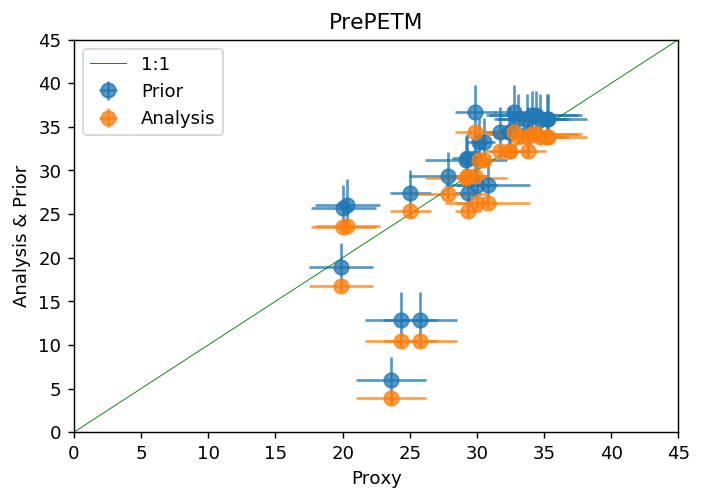

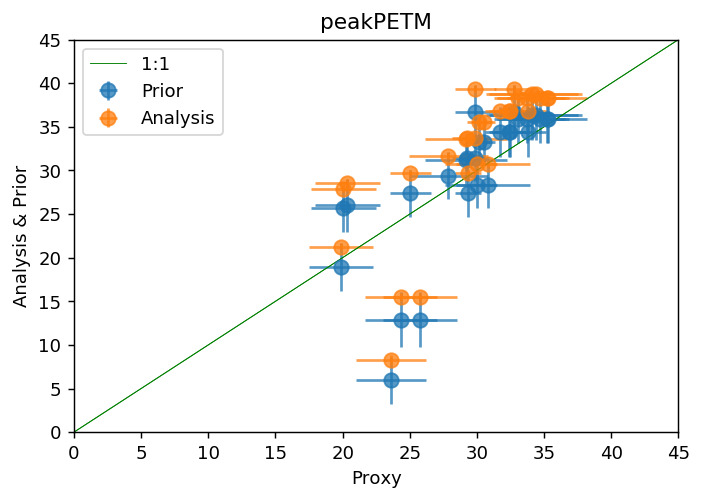

In [121]:
sstproxyfilesum = 'petmproxy3slices_v0.0.12_sst_DA_prePETM -peakPETM.csv'
proxy_rawfile1 = yml_dict['core']['proj_dir']+'/wrk/' + sstproxyfilesum 
lim1 = 0
lim2 = 45
print(' ########## Read proxies database ########## ')
### read proxies database ###
proxies1 = pandas.read_csv(proxy_rawfile1)
data1 = proxies['sst_peakPETMmean'][:] - proxies['sst_prePETMmean'][:]
analysis1 = proxies['sst_analysis_peak'][:] - proxies['sst_analysis_pre'][:]

fig = plt.figure()
kwargs = dict(alpha=0.75, marker='o', markersize=8, linestyle='',label = 'Prior')
plt.plot(np.array([lim1,lim2]), np.array([lim1,lim2]), color='green',linewidth=.5)
plt.plot(data1,analysis1,**kwargs)
plt.xlim([0, 16])
plt.ylim([4, 5.5])

fig = plt.figure()
plt.plot(np.array([lim1,lim2]), np.array([lim1,lim2]), color='green',linewidth=.5)
plt.errorbar(proxies1['sst_prePETMmean'][:], xerr = np.sqrt(proxies1['sst_prePETMvar'][:]), y=proxies1['sst_prior'][:], yerr = proxies1['sst_prior_std'][:],**kwargs)
plt.errorbar(proxies1['sst_prePETMmean'][:], xerr = np.sqrt(proxies1['sst_prePETMvar'][:]), y=proxies1['sst_analysis_pre'][:], yerr = proxies1['sst_analysis_std_pre'][:],**kwargs)
plt.xlim([lim1, lim2])
plt.ylim([lim1, lim2])
plt.legend(['1:1','Prior','Analysis'])
plt.xlabel('Proxy')
plt.ylabel('Analysis & Prior')
plt.title('PrePETM')
fig = plt.figure()
plt.plot(np.array([lim1,lim2]), np.array([lim1,lim2]), color='green',linewidth=.5)
plt.errorbar(proxies1['sst_prePETMmean'][:], xerr = np.sqrt(proxies1['sst_prePETMvar'][:]), y=proxies1['sst_prior'][:], yerr = proxies1['sst_prior_std'][:],**kwargs)
plt.errorbar(proxies1['sst_prePETMmean'][:], xerr = np.sqrt(proxies1['sst_prePETMvar'][:]), y=proxies1['sst_analysis_peak'][:], yerr = proxies1['sst_analysis_std_peak'][:],**kwargs)
plt.xlim([lim1, lim2])
plt.ylim([lim1, lim2])
plt.legend(['1:1','Prior','Analysis'])
plt.xlabel('Proxy')
plt.ylabel('Analysis & Prior')
plt.title('peakPETM')
plt.plot(np.array([lim1,lim2]), np.array([lim1,lim2]), color='green',linewidth=.5)


 /mnt/c/Users/mul450/Dropbox/git/deepDA/mlwrk/wrk/petmproxy3slices_v0.0.12_sst_DA_prePETM-peakPETM.csv
 len is 41
RMSE: prior vs proxy
3.721102633944145
RMSE: analysis vs proxy
3.780090821716504
CE: prior vs proxy
-0.1228003137174396
CE: analysis vs proxy
-0.15868049659683559


(4, 5.5)

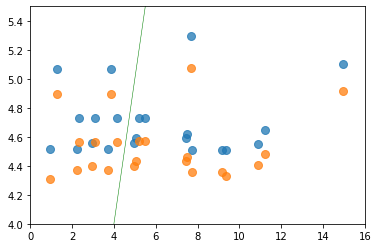

In [156]:
# read final data, plot data model comparison

file1 = yml_dict['core']['proj_dir']+'/wrk/' + 'petmproxy3slices_v0.0.12_sst_DA_prePETM-peakPETM.csv'
prox = proxies = pandas.read_csv(file1)
proxies_len0 = len(prox)

print(' {}'.format(file1))
print(' len is {}'.format(proxies_len0))
#print(' shape of proxy file {}'.format(prox.shape))

lat = prox['latbc'][:]
# pre = 0; peak = 1; e = std
data0 = prox['sst_prePETMmean'][:]
data0e = np.sqrt(prox['sst_prePETMvar'][:])
data1 = prox['sst_peakPETMmean'][:]
data1e = np.sqrt(prox['sst_peakPETMvar'][:])

analysis0 = prox['sst_analysispre'][:]
analysis0e = np.sqrt(prox['sst_analysis_stdpre'][:])
analysis1 = prox['sst_analysispeak'][:]
analysis1e = np.sqrt(prox['sst_analysis_stdpeak'][:])

model0e = np.sqrt(prox['sst_007std'][:])
model0 = prox['sst_007'][:]
model1 = prox['sst_008'][:]
model1e = np.sqrt(prox['sst_008std'][:])

datad = data1 - data0
modeld = model1 - model0
analysisd = analysis1 - analysis0

print('RMSE: prior vs proxy')
print(np.sqrt(np.nanmean((modeld - datad) ** 2, axis=0)))
print('RMSE: analysis vs proxy')
print(np.sqrt(np.nanmean((analysisd - datad) ** 2, axis=0)))
print('CE: prior vs proxy')
print(DeepDA_psm.CE_NS70(datad, modeld, 1))
print('CE: analysis vs proxy')
print(DeepDA_psm.CE_NS70(datad, analysisd, 1))


lim1 = 0
lim2 = 45
fig = plt.figure()
kwargs = dict(alpha=0.75, marker='o', markersize=8, linestyle='',label = 'Prior')
plt.plot(np.array([lim1,lim2]), np.array([lim1,lim2]), color='green',linewidth=.5)
plt.plot(datad,modeld,**kwargs)
plt.plot(datad,analysisd,**kwargs)
plt.xlim([0, 16])
plt.ylim([4, 5.5])